# PREAMBLE

In [1]:
import sys
from config import *
import pickle
import mne
from hypyp import utils
from hypyp import analyses
import numpy as np
from numpy import pi, arange, random, max
from scipy.io import loadmat
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm

# https://jitcde-common.readthedocs.io/en/stable/#installation
import os
os.environ["CC"] = "gcc"
# https://jitcdde.readthedocs.io/en/stable/
from jitcdde import jitcdde_input, y, t, input
from symengine import sin
from chspy import CubicHermiteSpline

# 1. ORDER PARAMETER VS CINTRA (FIRST LOOK)

In [ ]:
dti = loadmat("connectomes.mat")['cuban'] # self-connections (diagonals) are already 0

## NORMALISATION!!!!

# A = A-min(A) / (max(A)-min(A))      OR       A = A/sum(A)         OR(?)  dti/np.mean(dti)

nsfreq = 100.0
freq_mean = 4.0 # theta oscillations 

# Following options [0, 0.5, 1]
freq_std = 1.0
phase_noise = 0.5
amp_noise = 0.0
sensor_noise = 0.0

n = 90

100%|██████████| 100/100 [00:00<00:00, 1861.86it/s]


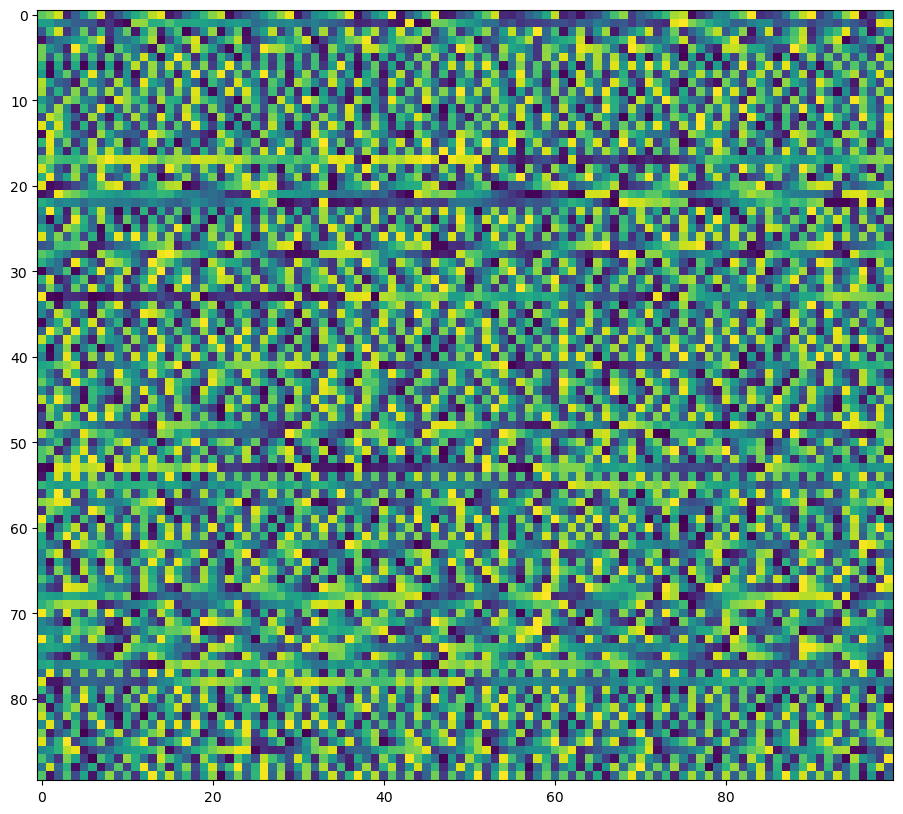

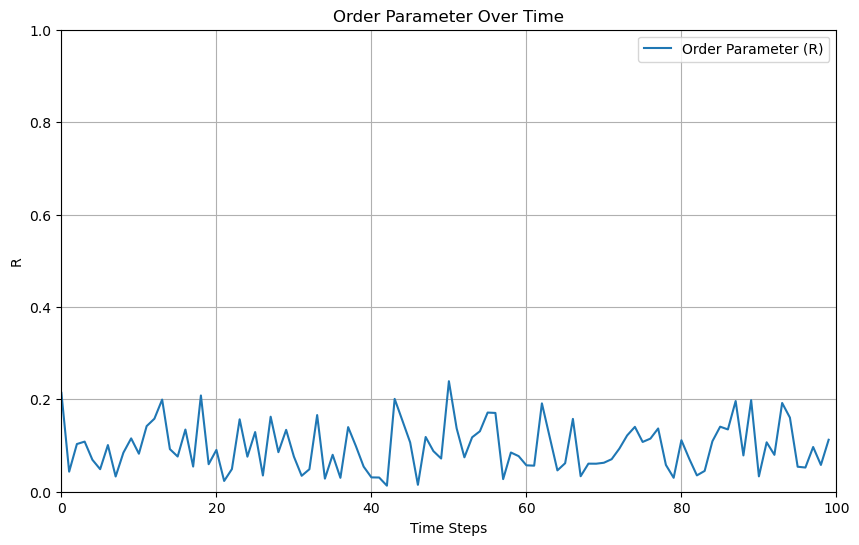

100%|██████████| 100/100 [00:11<00:00,  9.07it/s]


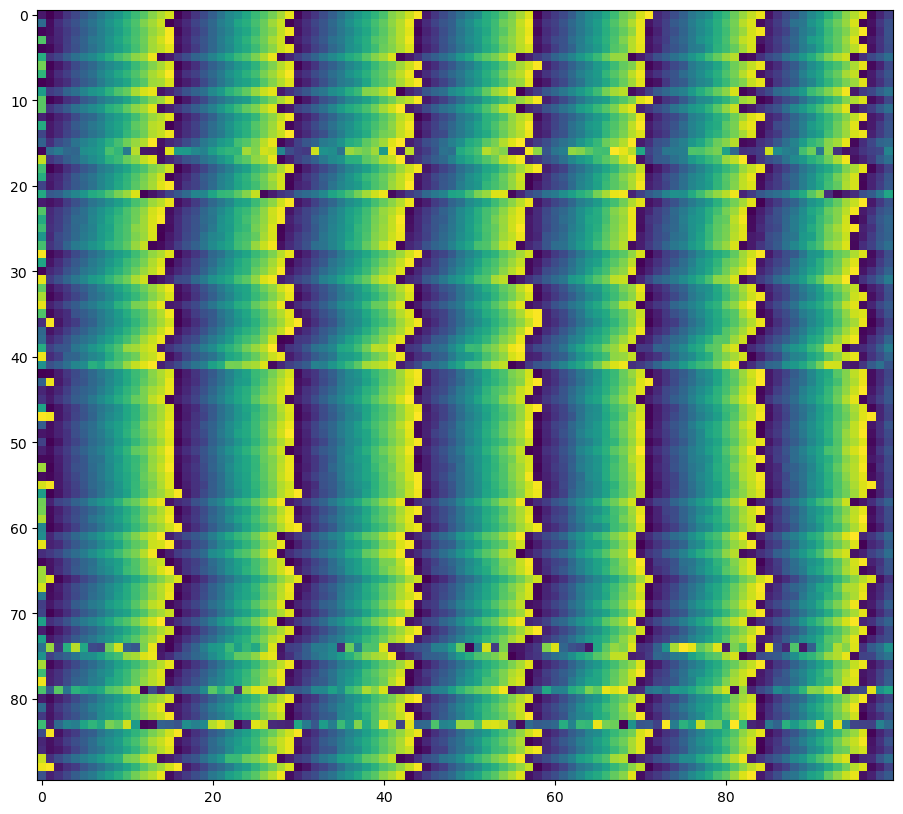

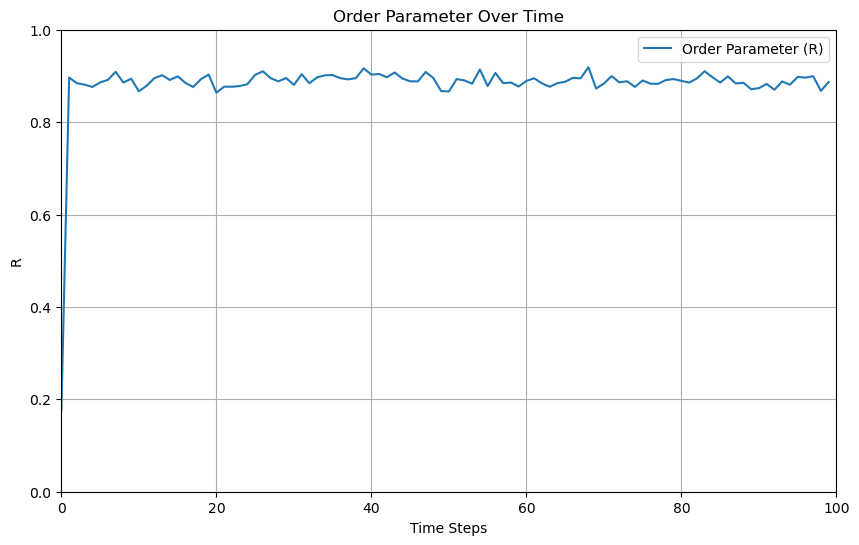

100%|██████████| 100/100 [00:17<00:00,  5.67it/s]


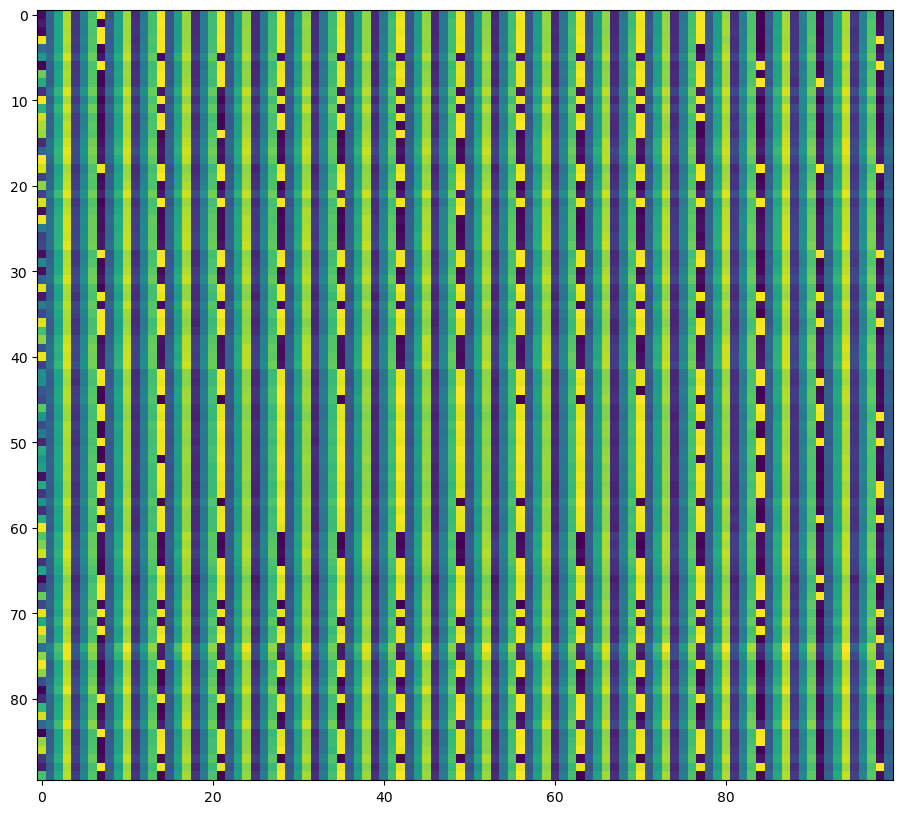

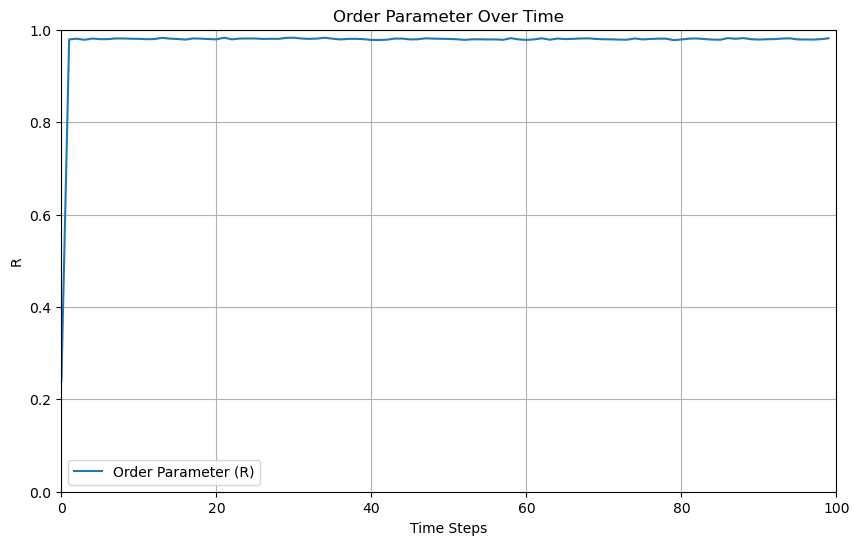

100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


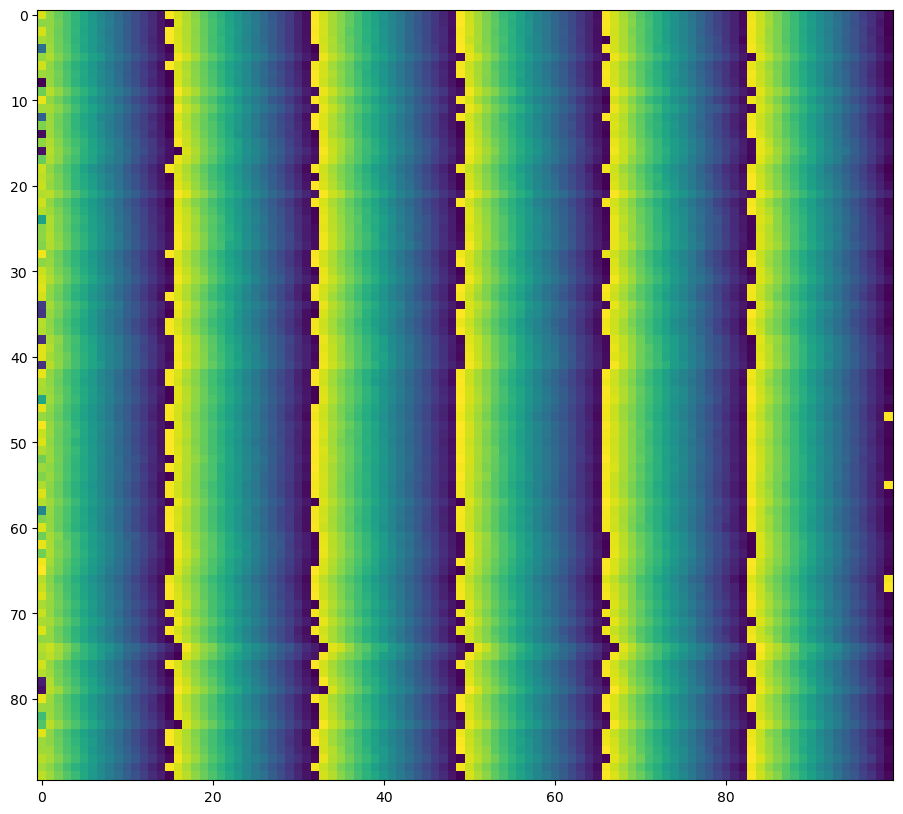

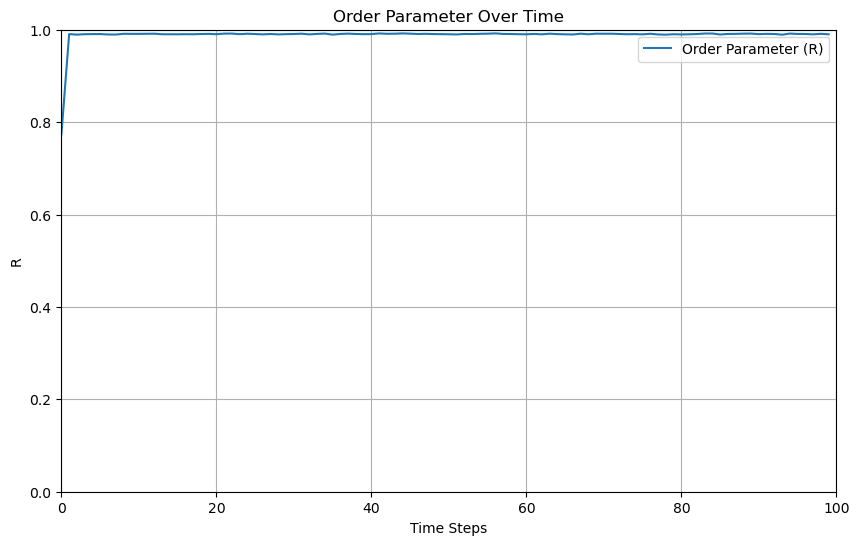

100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


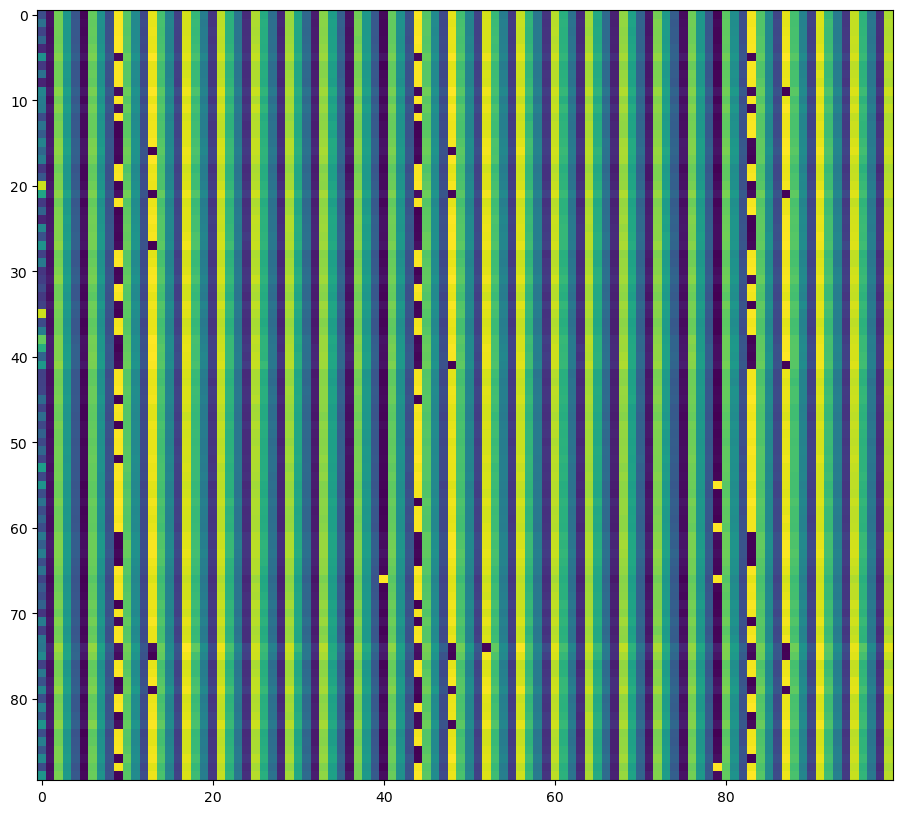

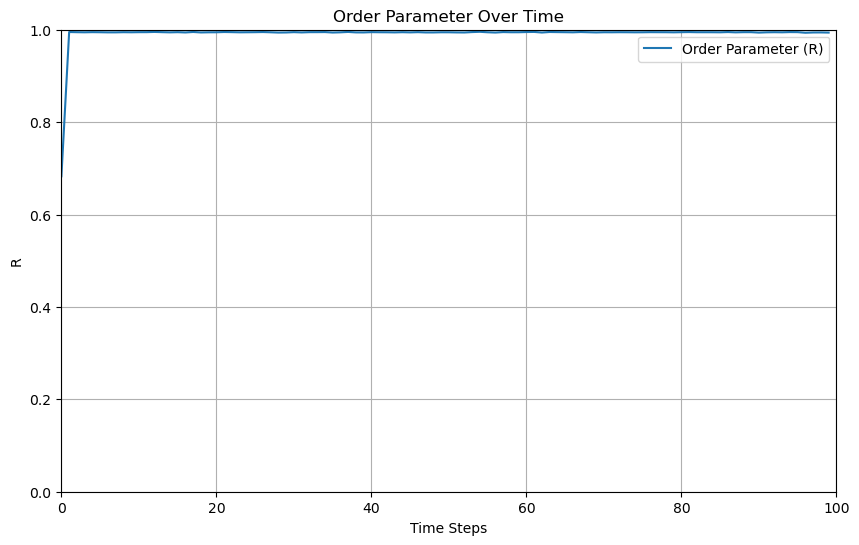

Simulating: 100%|██████████| 5/5 [05:10<00:00, 62.01s/it]


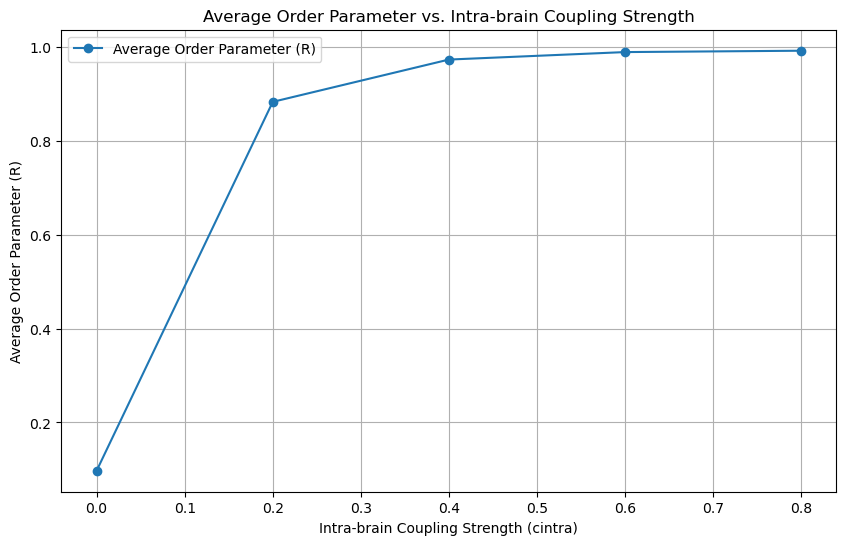

In [ ]:

cintra_values = np.arange(0.0, 1.0, 0.2)
R_avg_values = []  # To collect average R values for each cintra

w_d = np.array(loadmat("distance.mat")['distance'])
pulsations = (np.random.randn(1, n) * freq_std_factor * freq_std + freq_mean) * (2 * pi) / (sfreq)
times = arange(0, (n_times + 2) * sfreq, 1)

velocity = 1.65 # 6 or 1.65 (Dumas e2012)?


cintra = 0

def kuramotos():
        for i in range(n):
            yield ω[i] + 0.1 * (sum(
                A[j, i] * sin(y(j, t - τ[i, j]) - y(i))
                for j in range(n)
            ) + phase_noise * input(i))

for cintra in tqdm(cintra_values, desc='Simulating'):
    
    # Intra-brain coupling
    w_c = np.array(dti * cintra)

    ω = pulsations.flatten()
    A = w_c
    τ = sfreq * w_d / velocity

    input_data = np.random.normal(size=(len(times), n))
    input_spline = CubicHermiteSpline.from_data(times, input_data)


    DDE = jitcdde_input(f_sym=kuramotos,
                            n=n,
                            input=input_spline,
                            verbose=True)

    DDE.compile_C(simplify=False, do_cse=False, chunk_size=1)
    DDE.set_integration_parameters(rtol=0.0001, atol=0.0000001)
    DDE.constant_past(random.uniform(0, 2 * pi, n), time=0.0)
    DDE.integrate_blindly(max(τ), 1)

    output = []
    for time in tqdm(DDE.t + arange(0, 10000, 100)):    ## THIS WILL BE CHANGED IN THE NEXT SECTION!
	    output.append([*DDE.integrate(time) % (2*pi)])
         
    output_plot = np.transpose(np.array(output))
    plt.figure(figsize=(20, 10))
    plt.imshow(output_plot)

    phases = np.array(output)
    R = np.abs(np.mean(np.exp(1j * phases), axis=1))
    R_avg = np.mean(R)  # Average R over time for steady-state estimate
    R_avg_values.append(R_avg)

    plt.figure(figsize=(10, 6))
    plt.plot(R, label='Order Parameter (R)')
    plt.xlabel('Time Steps')
    plt.ylabel('R')
    plt.xlim(0,np.max(phases.shape[0]))
    plt.ylim(0, 1)
    plt.title('Order Parameter Over Time')
    plt.grid(True)
    plt.show()
         

plt.figure(figsize=(10, 6))
plt.plot(cintra_values, R_avg_values, '-o', label='Average Order Parameter (R)')
plt.xlabel('Intra-brain Coupling Strength (cintra)')
plt.ylabel('Average Order Parameter (R)')
plt.title('Average Order Parameter vs. Intra-brain Coupling Strength')
plt.grid(True)
plt.show()
    

However, the gradients are inconsistent because the integration is not adapting to the respective oscillation (I have erroneously used a global time gradient).




NAMELY, FROM


times = arange(0, (n_times + 2) * sfreq, 1)

...

for time in tqdm(DDE.t + arange(0, 10000, 100)):





TO 





times = arange(0, n_times, 1. / float(sfreq))

...

for time in tqdm(DDE.t + times):

# 2. NORMALISING TIME STEPS

THE GRAPHS BELOW DEMONSTRATE CINTRA = [0, 0.2, 0.4, 0.6, 0.8, 1] for the following specifications:

nsfreq = 100.0

freq_mean = 4.0 # theta oscillations 

freq_std = 1.0

phase_noise = 0.5

amp_noise = 0.0

sensor_noise = 0.0


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:00<00:00, 24471.85it/s]


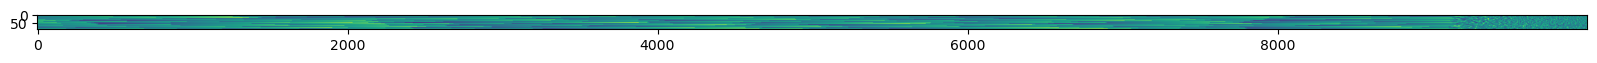

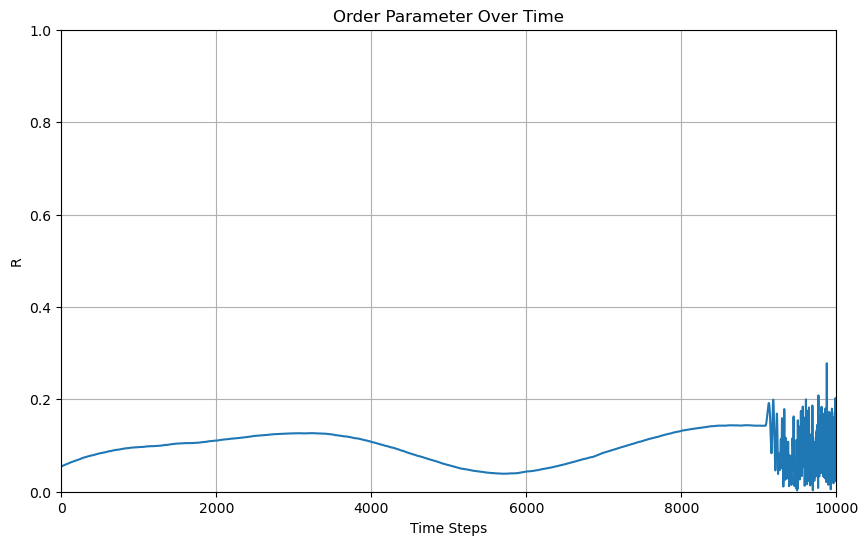

ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:03<00:00, 2856.42it/s]


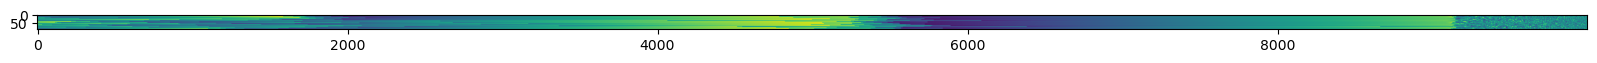

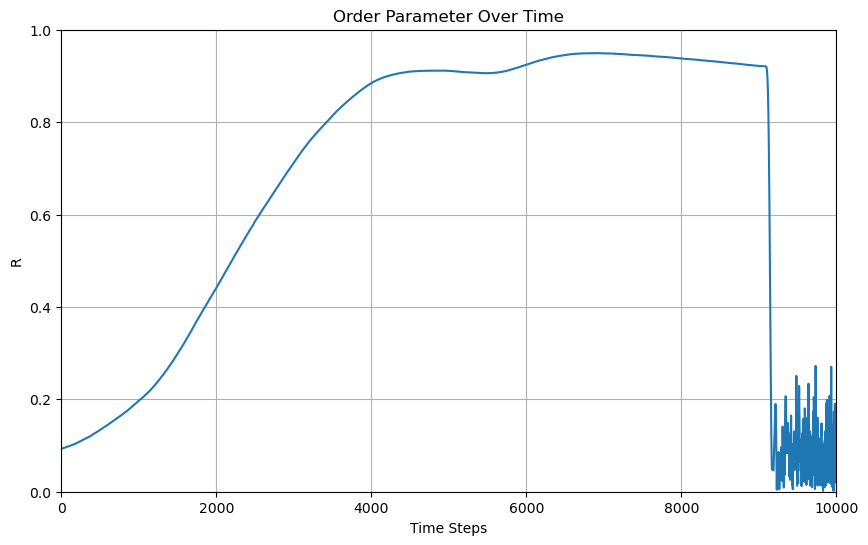

ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:04<00:00, 2225.80it/s]


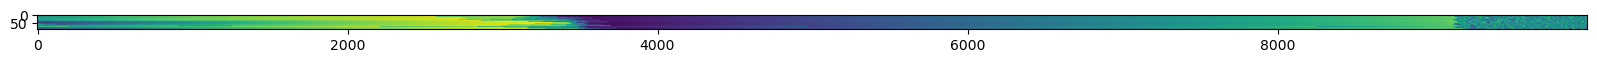

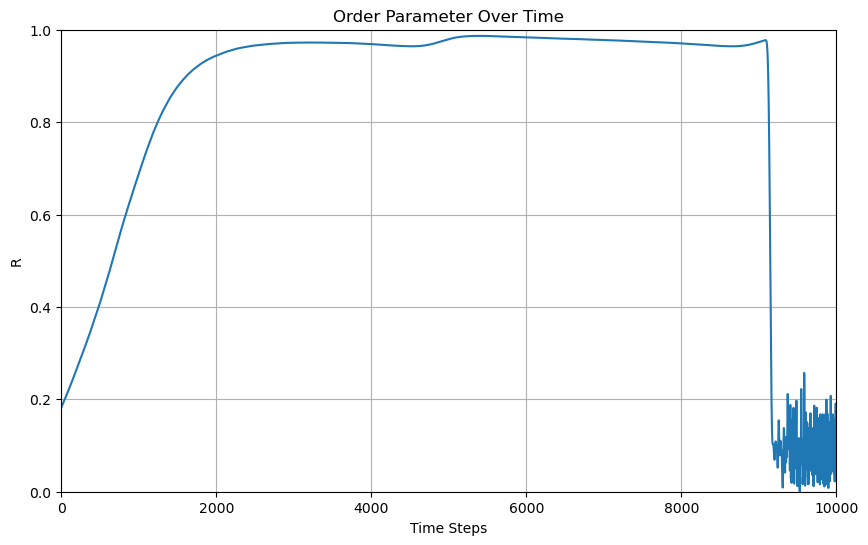

ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:05<00:00, 1703.88it/s]


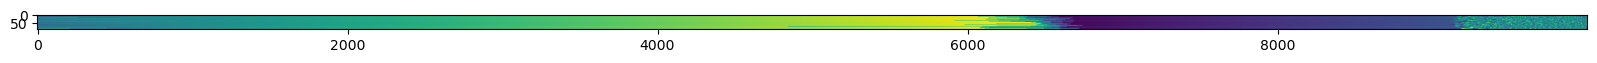

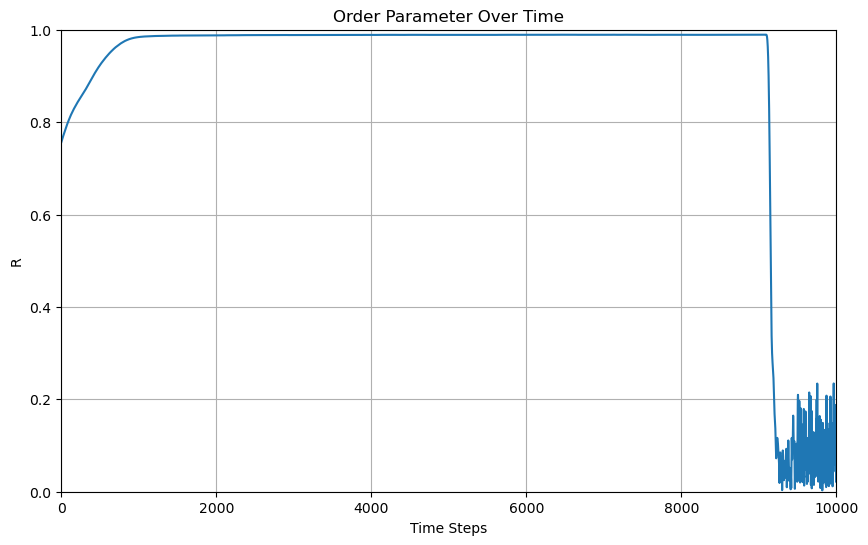

ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


DDE.t: 9.150162697654958


100%|██████████| 10000/10000 [00:08<00:00, 1204.70it/s]


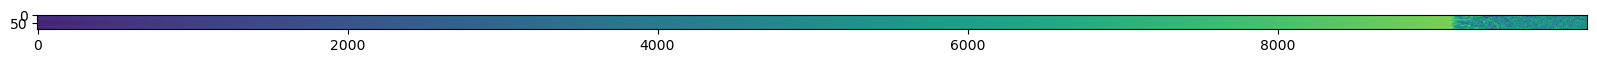

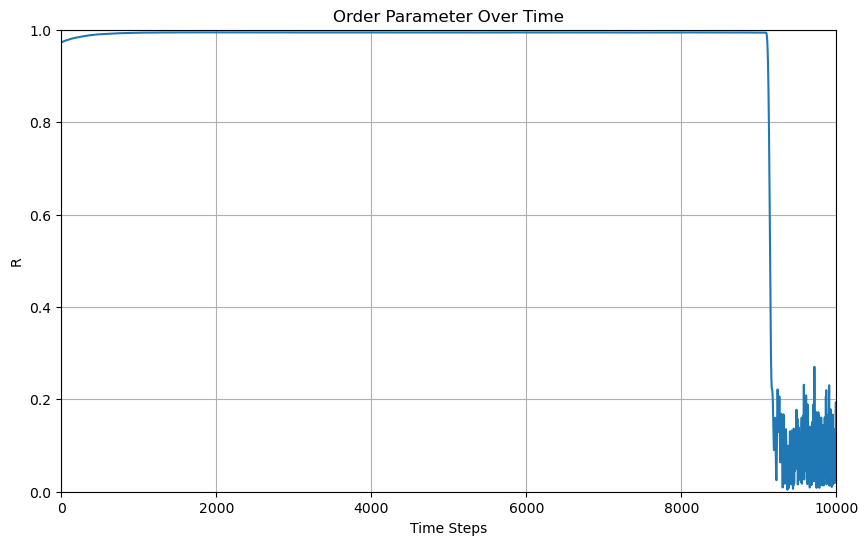

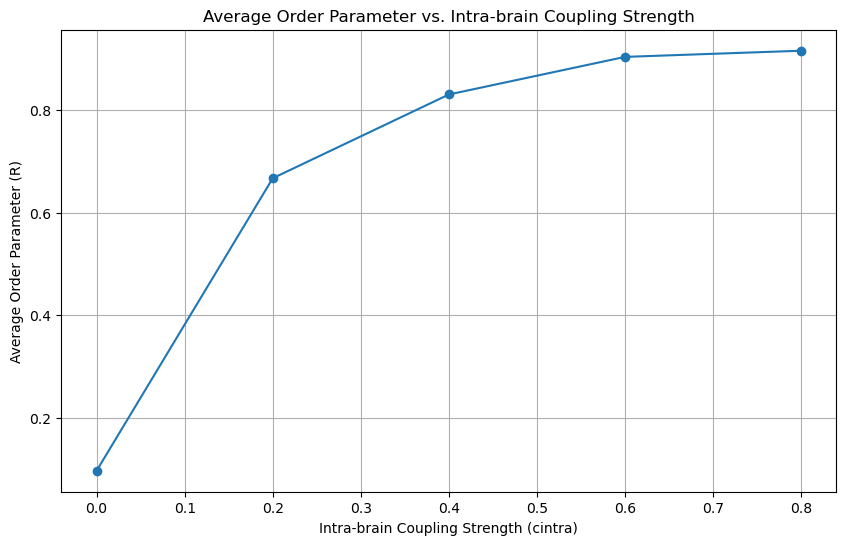

In [57]:
cintra = 0
cintra_values = np.arange(0.0, 1.0, 0.2)
R_avg_values = []  # To collect average R values for each cintra

w_d = np.array(loadmat("distance.mat")['distance'])
pulsations = (np.random.randn(1, n) * freq_std_factor * freq_std + freq_mean) * (2 * pi) / (sfreq)

times = arange(0, n_times, 1. / float(sfreq))

velocity = 1.65 # 6 or 1.65 (Dumas e2012)?


def kuramotos():
        for i in range(n):
            yield ω[i] + 0.1 * (sum(
                A[j, i] * sin(y(j, t - τ[i, j]) - y(i))
                for j in range(n)
            ) + phase_noise * input(i))

for cintra in cintra_values:
    
    # Intra-brain coupling
    w_c = np.array(dti * cintra)

    ω = pulsations.flatten()
    A = w_c
    τ = sfreq * w_d / velocity

    input_data = np.random.normal(size=(len(times), n))
    input_spline = CubicHermiteSpline.from_data(times, input_data)


    DDE = jitcdde_input(f_sym=kuramotos,
                            n=n,
                            input=input_spline,
                            verbose=True)

    DDE.compile_C(simplify=False, do_cse=False, chunk_size=1)
    DDE.set_integration_parameters(rtol=0.0001, atol=0.0000001)
    DDE.constant_past(random.uniform(0, 2 * pi, n), time=0.0)
    DDE.integrate_blindly(max(τ), 1)
    # DDE.t: 9.150162697654958

    output = []
    for time in tqdm(DDE.t + times):
	    output.append([*DDE.integrate(time) % (2*pi)])
    
    phases = np.array(output)


    plt.figure(figsize=(20, 10))
    plt.imshow(np.transpose(phases))

    R = np.abs(np.mean(np.exp(1j * phases), axis=1))
    R_avg = np.mean(R)  # Average R over time for steady-state estimate
    R_avg_values.append(R_avg)

    plt.figure(figsize=(10, 6))
    plt.plot(R, label='Order Parameter (R)')
    plt.xlabel('Time Steps')
    plt.ylabel('R')
    plt.xlim(0,np.max(phases.shape[0]))
    plt.ylim(0, 1)
    plt.title('Order Parameter Over Time')
    plt.grid(True)
    plt.show()
         

plt.figure(figsize=(10, 6))
plt.plot(cintra_values, R_avg_values, '-o', label='Average Order Parameter (R)')
plt.xlabel('Intra-brain Coupling Strength (cintra)')
plt.ylabel('Average Order Parameter (R)')
plt.title('Average Order Parameter vs. Intra-brain Coupling Strength')
plt.grid(True)
plt.show()
    

# VARYING NOISE PARAMETERS WITH CINTER

In [58]:
dti = loadmat("connectomes.mat")['cuban'] # self-connections (diagonals) are already 0

## NORMALISATION!!!!
# A = A-min(A) / (max(A)-min(A))      OR       A = A/sum(A)         OR(?)  dti/np.mean(dti)

nsfreq = 100.0
freq_mean = 4.0 # theta oscillations 
freq_std_factor = 1

n = 90

1.0


Currently calculating for freq_std: 0, phase_noise: 0, amp_noise: 0, sensor_noise: 0...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 46954.76it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0, sensor_noise: 0 occurs at time: 0.84.


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 32709.25it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0, sensor_noise: 0 occurs at time: 0.0.


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 27578.61it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0, sensor_noise: 0 occurs at time: 0.0.


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 21702.19it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0, sensor_noise: 0 occurs at time: 0.0.


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 14831.98it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0, sensor_noise: 0 occurs at time: 0.0.


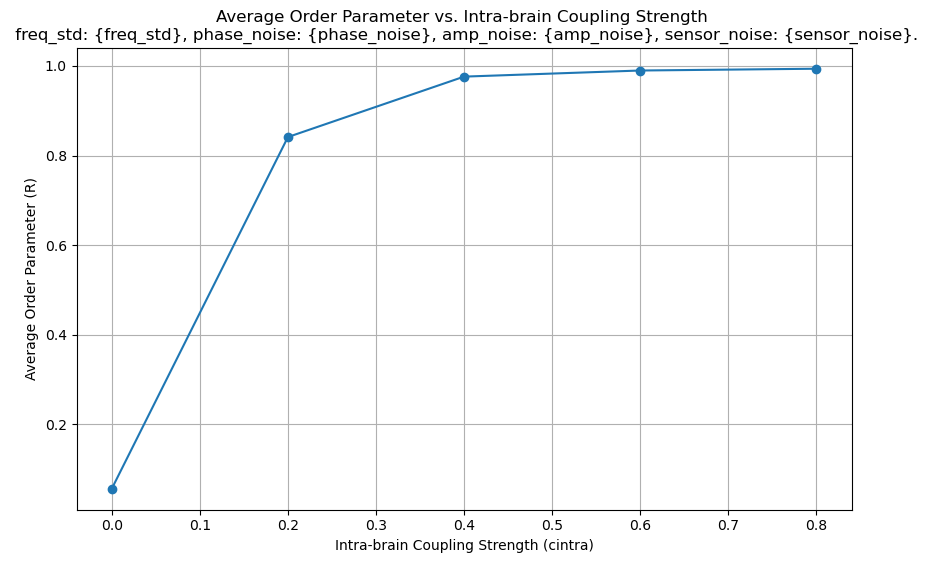

Currently calculating for freq_std: 0, phase_noise: 0, amp_noise: 0, sensor_noise: 0.5...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 22214.43it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0, sensor_noise: 0.5 occurs at time: 5.53.


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 25283.87it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0, sensor_noise: 0.5 occurs at time: 0.0.


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 18263.48it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0, sensor_noise: 0.5 occurs at time: 6.0.


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 22763.84it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0, sensor_noise: 0.5 occurs at time: 0.0.


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 22765.72it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0, sensor_noise: 0.5 occurs at time: 0.0.


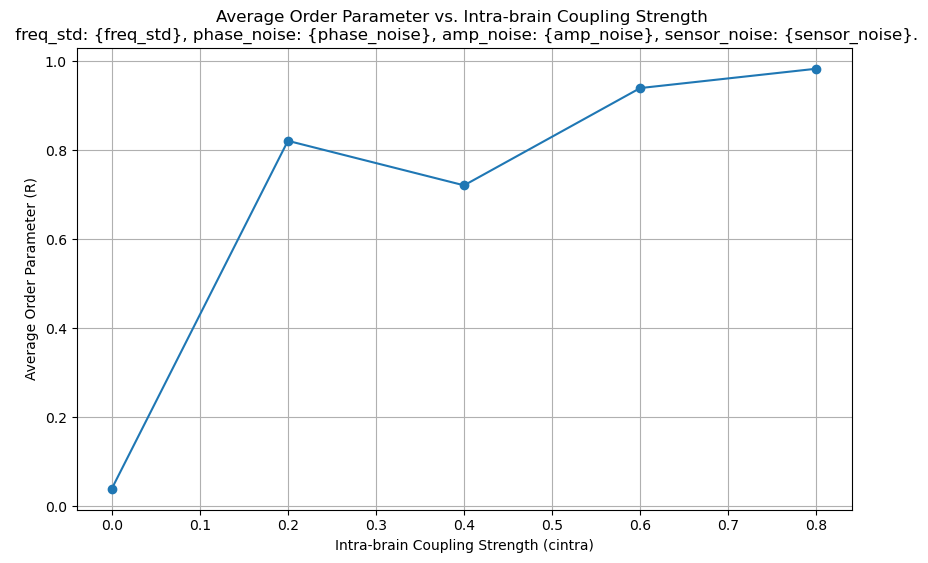

Currently calculating for freq_std: 0, phase_noise: 0, amp_noise: 0, sensor_noise: 1...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 27137.18it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0, sensor_noise: 1 occurs at time: 11.540000000000001.


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 17640.89it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0, sensor_noise: 1 occurs at time: 0.0.


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 19975.66it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0, sensor_noise: 1 occurs at time: 0.0.


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 25696.36it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0, sensor_noise: 1 occurs at time: 0.0.


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 23783.92it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0, sensor_noise: 1 occurs at time: 0.0.


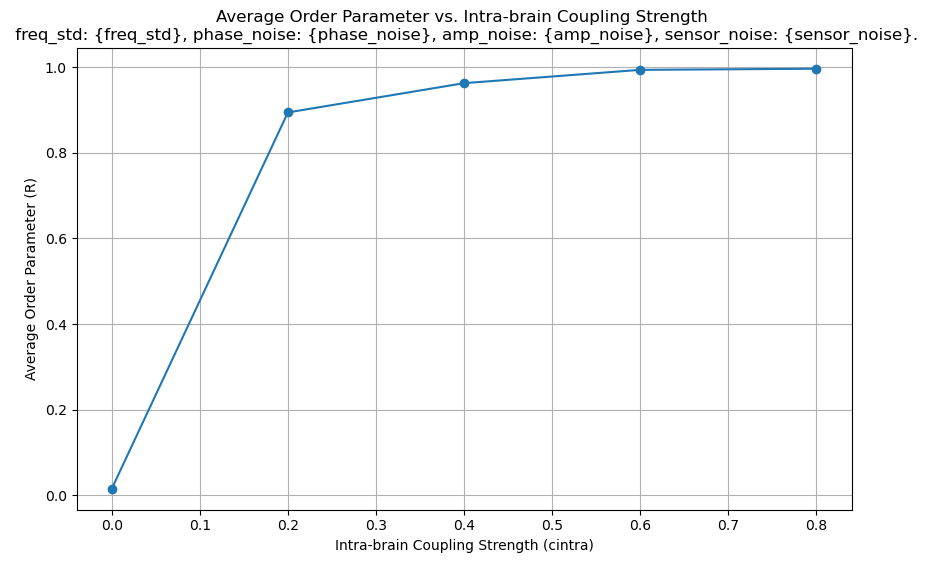

Currently calculating for freq_std: 0, phase_noise: 0, amp_noise: 0.5, sensor_noise: 0...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 49184.24it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0.5, sensor_noise: 0 occurs at time: 3.79.


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 30546.13it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0.5, sensor_noise: 0 occurs at time: 11.450000000000001.


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 25879.77it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0.5, sensor_noise: 0 occurs at time: 0.0.


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 20843.76it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0.5, sensor_noise: 0 occurs at time: 0.0.


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 23132.95it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0.5, sensor_noise: 0 occurs at time: 0.0.


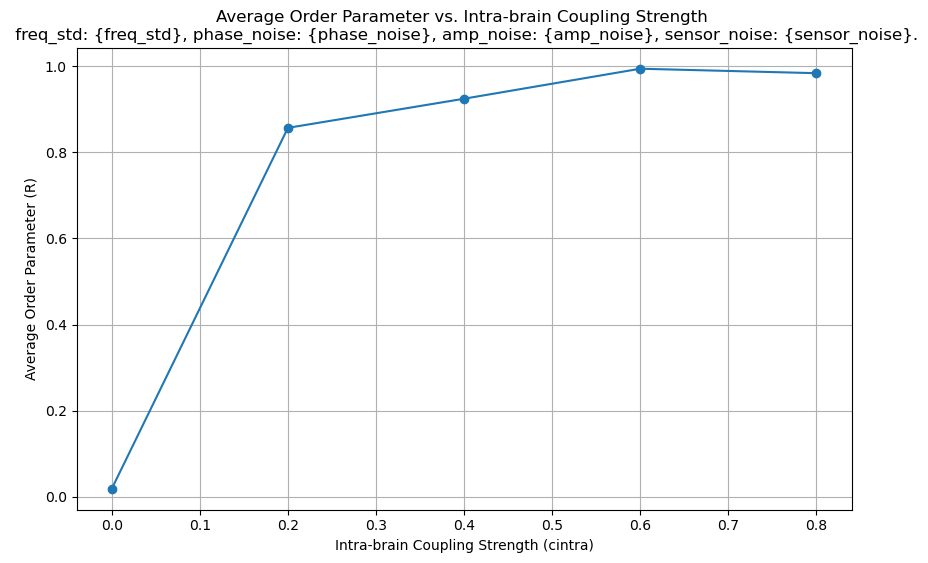

Currently calculating for freq_std: 0, phase_noise: 0, amp_noise: 0.5, sensor_noise: 0.5...


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 50178.42it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0.5, sensor_noise: 0.5 occurs at time: 3.93.


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 32642.73it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0.5, sensor_noise: 0.5 occurs at time: 0.0.


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 28678.18it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0.5, sensor_noise: 0.5 occurs at time: 0.0.


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored
100%|██████████| 10000/10000 [00:00<00:00, 26570.65it/s]


Critical point for freq_std: 0, phase_noise: 0, amp_noise: 0.5, sensor_noise: 0.5 occurs at time: 0.0.


ld: warning: duplicate -rpath '/Users/edoardochidichimo/anaconda3/lib' ignored


KeyboardInterrupt: 

In [59]:
cintra = 0
cintra_values = np.arange(0.0, 1.0, 0.2)
value_range = [0,0.5,1]

w_d = np.array(loadmat("distance.mat")['distance'])
times = arange(0, n_times, 1. / float(sfreq))
velocity = 1.65 # 6 or 1.65 (Dumas e2012)?

results = {}

def kuramotos():
        for i in range(n):
            yield ω[i] + 0.1 * (sum(
                A[j, i] * sin(y(j, t - τ[i, j]) - y(i))
                for j in range(n)
            ) + phase_noise * input(i))

for freq_std in value_range:

    pulsations = (np.random.randn(1, n) * freq_std_factor * freq_std + freq_mean) * (2 * pi) / (sfreq)
    ω = pulsations.flatten()

    for phase_noise in value_range:
        for amp_noise in value_range:
            for sensor_noise in value_range:


                R_avg_values = []  # To collect average R values for each cintra
                noise_setting = (freq_std, phase_noise, amp_noise, sensor_noise)
                results[noise_setting] = []


                for cintra in cintra_values:
                    
                    print(f"Currently calculating for freq_std: {freq_std}, phase_noise: {phase_noise}, amp_noise: {amp_noise}, sensor_noise: {sensor_noise}, cintra: {cintra}...")

                    # Intra-brain coupling
                    w_c = np.array(dti * cintra)

                    A = w_c
                    τ = sfreq * w_d / velocity

                    input_data = np.random.normal(size=(len(times), n))
                    input_spline = CubicHermiteSpline.from_data(times, input_data)


                    DDE = jitcdde_input(f_sym=kuramotos,
                                            n=n,
                                            input=input_spline,
                                            verbose=True)

                    DDE.compile_C(simplify=False, do_cse=False, chunk_size=1)
                    DDE.set_integration_parameters(rtol=0.0001, atol=0.0000001)
                    DDE.constant_past(random.uniform(0, 2 * pi, n), time=0.0)
                    DDE.integrate_blindly(max(τ), 1)
                    # DDE.t: 9.150162697654958

                    output = []
                    for time in tqdm(DDE.t + times):
                        output.append([*DDE.integrate(time) % (2*pi)])
                    
                    phases = np.array(output)


                    # plt.figure(figsize=(20, 10))
                    # plt.imshow(np.transpose(phases))

                    R = np.abs(np.mean(np.exp(1j * phases), axis=1))
                    R_avg = np.mean(R)  # Average R over time for steady-state estimate
                    R_avg_values.append(R_avg)

                    results[noise_setting] = R_avg_values

                    # plt.figure(figsize=(10, 6))
                    # plt.plot(R, label='Order Parameter (R)')
                    # plt.xlabel('Time Steps')
                    # plt.ylabel('R')
                    # plt.xlim(0,np.max(phases.shape[0]))
                    # plt.ylim(0, 1)
                    # plt.title('Order Parameter Over Time')
                    # plt.grid(True)
                    # plt.show()

                    # CHECK FOR CRITICAL VALUE
                    dR_dt = np.gradient(R, times)

                    threshold = np.std(dR_dt) * 2  # Can say critical points occurs two standard deviations above the mean derivative
                    significant_change_indices = np.where(np.abs(dR_dt) > threshold)[0]

                    if significant_change_indices.size > 0:
                        critical_time_point = times[significant_change_indices[0]]
                        print(f"Critical point at time: {critical_time_point}.")
                    else:
                        print("No clear critical point detected based on the threshold.")
                
                results[noise_setting] = R_avg_values.copy()

                plt.figure(figsize=(10, 6))
                plt.plot(cintra_values, R_avg_values, '-o', label='Average Order Parameter (R)')
                plt.xlabel('Intra-brain Coupling Strength (cintra)')
                plt.ylabel('Average Order Parameter (R)')
                plt.title(f'Average Order Parameter vs. Intra-brain Coupling Strength \n freq_std: {freq_std}, phase_noise: {phase_noise}, amp_noise: {amp_noise}, sensor_noise: {sensor_noise}.')
                plt.grid(True)
                plt.show()
    

for noise_setting, R_avg_values in results.items():
    freq_std, phase_noise, amp_noise, sensor_noise = noise_setting  # Unpack the noise setting
    plt.figure(figsize=(10, 6))
    plt.plot(cintra_values, R_avg_values, '-o', label='Average Order Parameter (R)')
    plt.xlabel('Intra-brain Coupling Strength (cintra)')
    plt.ylabel('Average Order Parameter (R)')
    plt.title(f'Average Order Parameter vs. Intra-brain Coupling Strength \n freq_std: {freq_std}, phase_noise: {phase_noise}, amp_noise: {amp_noise}, sensor_noise: {sensor_noise}.')
    plt.grid(True)
    plt.legend()
    plt.show()